# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv",delimiter = ';')

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv",delimiter = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias_extra = azdias.copy()
azdias.head(2)
feat_info.head(2)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"


In [4]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [5]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,LP_FAMILIE_FEIN,person,ordinal,[-1]
freq,1,43,49,26


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
#Checking for the number of Nan values in the azdias dataframe
azdias.isna().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [7]:
#Checking for the number of Nan values in the feat_info dataframe
feat_info.isna().sum()

attribute             0
information_level     0
type                  0
missing_or_unknown    0
dtype: int64

In [8]:
#Checking for the number of missing values in the azdias dataframe
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [9]:
# Function to parse the 'missing_or_unknown' column and return a list of codes
def parse_missing_or_unknown(missing_or_unknown):
    # Remove brackets and split the string into a list of codes
    return missing_or_unknown.strip('[]').split(',')

# Iterate through feat_info to clean the data
for index, row in feat_info.iterrows():
    feature = row['attribute']
    missing_or_unknown = parse_missing_or_unknown(row['missing_or_unknown'])
    
    # Iterate through the corresponding column in the main dataset
    for code in missing_or_unknown:
        code = code.strip()
        # Handle special cases where the code is 'X' or 'XX'
    
        if code == 'X' or code == 'XX':
            
            code = code.replace('X', '-1').replace('XX', '-1')
            # Convert matching values to NumPy NaN and assign back to the column
            azdias[feature] = azdias[feature].replace(code, np.nan)
            
            

            

In [10]:
#Viewing the number of missing values for the first 5 columns
azdias.isnull().sum().head(5)

AGER_TYP                   0
ALTERSKATEGORIE_GROB       0
ANREDE_KZ                  0
CJT_GESAMTTYP           4854
FINANZ_MINIMALIST          0
dtype: int64

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

check_missing_column_values = azdias.isnull().sum()
check_missing_column_values

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [12]:
missing_column_values = check_missing_column_values[check_missing_column_values > 0]

missing_column_values.sort_values(inplace=True, ascending=False)
missing_column_values

KK_KUNDENTYP           584612
KBA05_ANTG3            133324
KBA05_ANTG2            133324
KBA05_ANTG4            133324
KBA05_BAUMAX           133324
KBA05_GBZ              133324
KBA05_ANTG1            133324
MOBI_REGIO             133324
KKK                    121196
REGIOTYP               121196
PLZ8_ANTG1             116515
PLZ8_ANTG2             116515
PLZ8_ANTG3             116515
PLZ8_ANTG4             116515
PLZ8_BAUMAX            116515
PLZ8_HHZ               116515
PLZ8_GBZ               116515
W_KEIT_KIND_HH         107602
KBA13_ANZAHL_PKW       105800
CAMEO_DEUG_2015         98979
CAMEO_INTL_2015         98979
CAMEO_DEU_2015          98979
ORTSGR_KLS9             97216
RELAT_AB                97216
ARBEIT                  97216
ANZ_HH_TITEL            97008
EWDICHTE                93740
BALLRAUM                93740
INNENSTADT              93740
GEBAEUDETYP_RASTER      93155
WOHNLAGE                93148
OST_WEST_KZ             93148
MIN_GEBAEUDEJAHR        93148
GEBAEUDETY

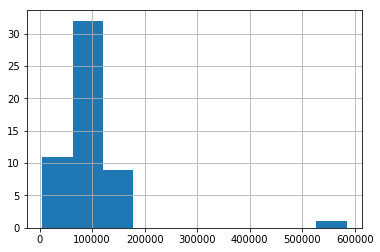

In [13]:
missing_column_values.hist()

In [14]:
# Investigate patterns in the amount of missing data in each column.
# Calculate the percentage of missing values for each column
missing_percentage = (azdias.isnull().mean() * 100).sort_values()
missing_percentage

AGER_TYP                  0.000000
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT                0.000000
SEMIO_LUST                0.000000
SEMIO_ERL                 0.000000
PRAEGENDE_JUGENDJAHRE     0.000000
SEMIO_KULT                0.000000
SEMIO_KRIT                0.000000
SEMIO_DOM                 0.000000
SEMIO_KAEM                0.000000
SEMIO_PFLICHT             0.000000
SEMIO_TRADV               0.000000
SHOPPER_TYP               0.000000
VERS_TYP                  0.000000
SEMIO_RAT                 0.000000
NATIONALITAET_KZ          0.000000
ZABEOTYP                  0.000000
FINANZ_MINIMALIST         0.000000
ALTERSKATEGORIE_GROB      0.000000
ANREDE_KZ                 0.000000
FINANZ_SPARER             0.000000
HEALTH_TYP                0.000000
GREEN_AVANTGARDE          0.000000
FINANZ_VORSORGER          0.000000
GEBURTSJAHR               0.000000
FINANZTYP           

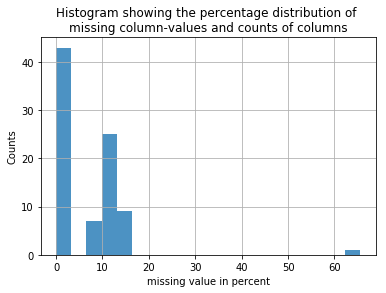

In [15]:
# Create a bar plot
plt.hist(missing_percentage, bins=20, alpha = 0.8);
plt.xlabel('missing value in percent')
plt.ylabel('Counts')
plt.title('Histogram showing the percentage distribution of \nmissing column-values and counts of columns')
plt.grid(True)
plt.show()

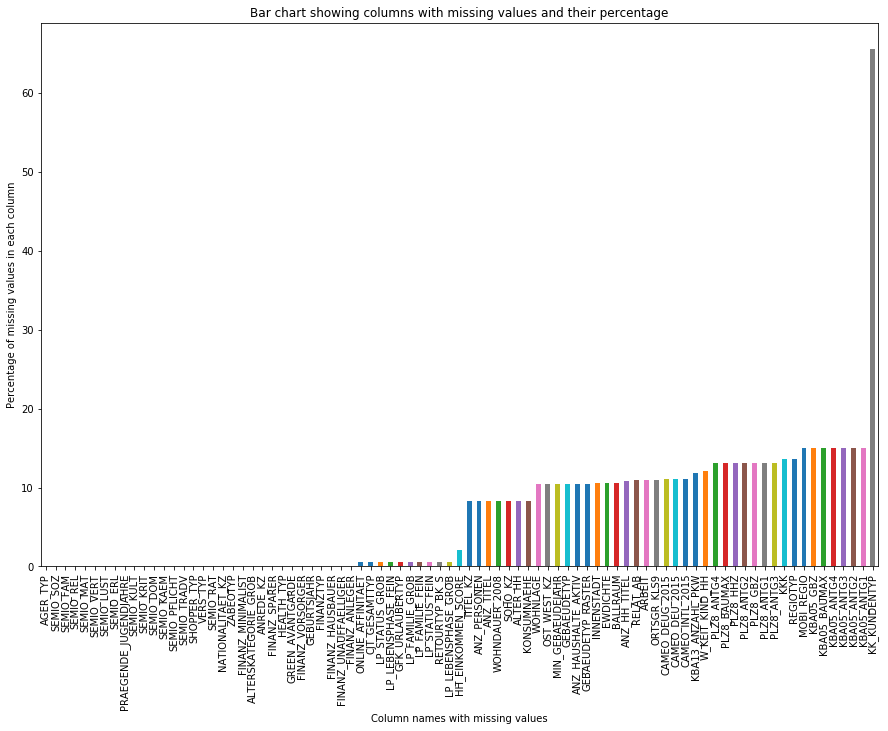

There are 85 columns with missing values.


In [16]:
missing_percentage.plot.bar(figsize=(15,10))
plt.xlabel('Column names with missing values')
plt.ylabel('Percentage of missing values in each column')
plt.title('Bar chart showing columns with missing values and their percentage')
plt.show()
print("There are {} columns with missing values.".format(len(missing_percentage)))

In [17]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Define a threshold for the percentage of missing values, lets do columns with a percentage of more than 20 percentage
threshold = 20

# Calculate the percentage of missing values for each column
missing_percentage = (azdias.isnull().mean() * 100)

# Get the columns that have a percentage of missing values above the threshold

##outlier_columns = missing_percentage[missing_percentage > threshold].index


outlier_columns =[]
for col in azdias.columns:
    if (azdias[col].isnull().sum()/azdias.shape[0]) * 100 > 20:
        outlier_columns.append(col)

print(outlier_columns)

['KK_KUNDENTYP']


In [18]:
# Drop the outlier columns from the dataset
azdias = azdias.drop(outlier_columns, axis=1)

In [19]:
print( "# of columns in Azdias:", len(azdias.columns))
print( "# of columns removed from Azdias:", len(outlier_columns))
print( "Column removed from Azdias:", outlier_columns)

# of columns in Azdias: 84
# of columns removed from Azdias: 1
Column removed from Azdias: ['KK_KUNDENTYP']


#### Discussion 1.1.2: Assess Missing Data in Each Column

The column with the highest missing value is 'KK_KUNDENTYP' with most of the columns contain less than 20 percent missing value Therefore, using a thresold of 20%, 1 column ('KK_KUNDENTYP') was dropped.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

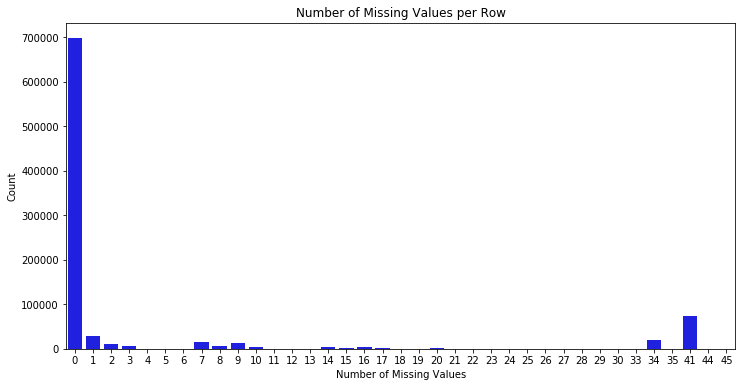

In [20]:
# How much data is missing in each row of the dataset?
missing_data_per_row = azdias.isnull().sum(axis=1)

# Create a bar plot to visualize the number of missing values per row
plt.figure(figsize=(12, 6))
sns.countplot(missing_data_per_row, color='blue')
plt.xlabel('Number of Missing Values')
plt.ylabel('Count')
plt.title('Number of Missing Values per Row')
plt.show()

In [21]:
# Add information about number of NaN for each row to the master dataset
azdias = azdias.assign(NAN_NUM= missing_data_per_row)
#azdias.head(5)

In [22]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Define a threshold for the number of missing values to create subsets
threshold = 0.05

# Create two subsets based on the number of missing values
subset_with_few_missing = azdias[azdias['NAN_NUM'] <= threshold]
subset_with_many_missing = azdias[azdias['NAN_NUM'] > threshold]

['HH_EINKOMMEN_SCORE' 'SEMIO_KAEM' 'SHOPPER_TYP' 'FINANZ_SPARER'
 'PRAEGENDE_JUGENDJAHRE']


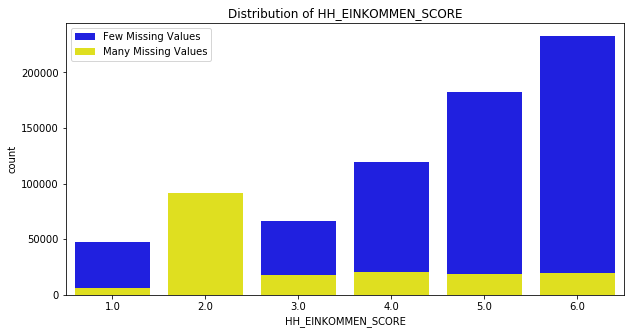

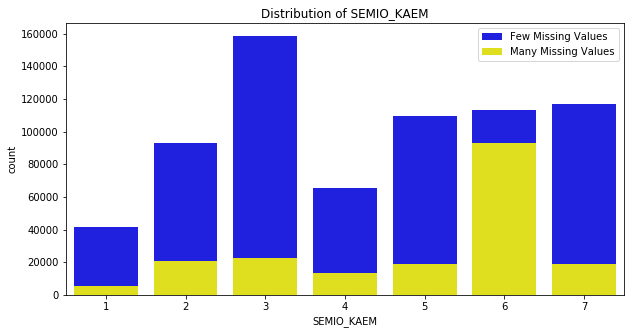

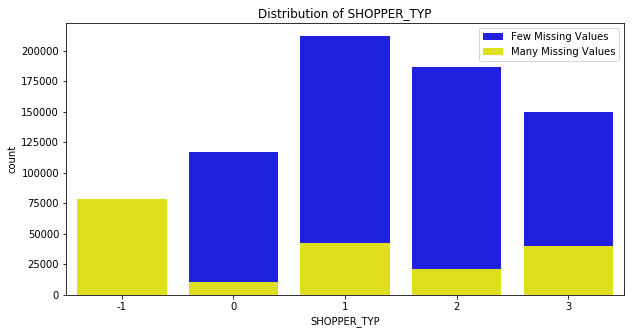

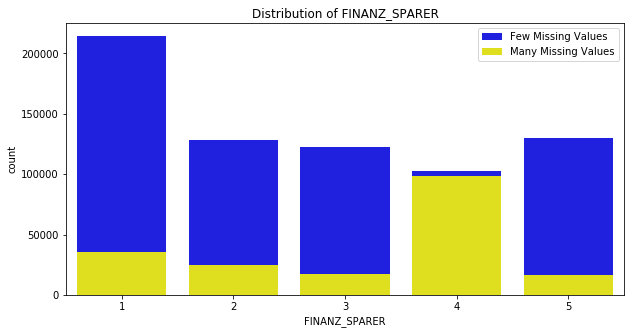

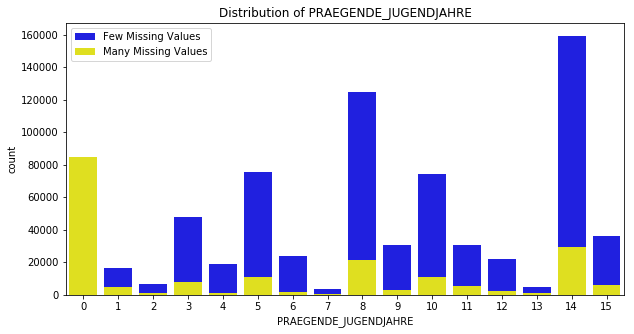

In [23]:
# Define a function to identify columns with few or no missing values
def get_columns_with_few_missing(df, threshold):
    return df.columns[df.isnull().mean() <= threshold]

# Get columns with few or no missing values
columns_with_few_missing = get_columns_with_few_missing(azdias, threshold)

# Select a sample of columns for comparison (at least five)
sample_columns = np.random.choice(columns_with_few_missing, 5, replace=False)
print(sample_columns)

# Compare the distribution of values between the two subsets
for column in sample_columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(subset_with_few_missing[column], label='Few Missing Values', color='blue')
    sns.countplot(subset_with_many_missing[column], label='Many Missing Values', color='yellow')

    plt.title(f'Distribution of {column}')
    plt.legend()
    plt.show()


In [24]:
#Dropping Rows with many value missing

print('rows before dropping null rows:', azdias.shape[0])

azdias = azdias[~azdias.index.isin(subset_with_many_missing.index)]

print('rows after dropping null rows:', azdias.shape[0])

rows before dropping null rows: 891221
rows after dropping null rows: 697859


#### Discussion 1.1.3: Assess Missing Data in Each Row

Based on these observations, it is reasonable to conclude that the two subsets of data are qualitatively different. The subset with few or no missing values is likely to be more reliable and suitable for analysis. The subset with many missing values may require additional data imputation or may be less informative due to the high number of missing values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [25]:
# How many features are there of each data type?
feat_info.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

In [26]:
# Have to drop this row because it no longer exists in the azdias dataframe. 

index_of_row = feat_info[feat_info['attribute'] == 'KK_KUNDENTYP'].index[0]
feat_info = feat_info.drop(index=index_of_row)



#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [27]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Select categorical features names
categorical_features = feat_info[feat_info.type == 'categorical'].attribute

# Define lists to store information
binary_variables = []
multi_level_variables = []
non_numeric_binary_variables = []

for feature in categorical_features:
    unique_values = azdias[feature].unique()
    
    if len(unique_values) == 2:
        binary_variables.append(feature)
        
        # Check if it's non-numeric
        if not all(isinstance(value, (int, float)) for value in unique_values):
            non_numeric_binary_variables.append(feature)
    else:
        multi_level_variables.append(feature)

# Print the results
print("Binary Variables:", binary_variables)
print("Multi-Level Variables:", multi_level_variables)
print("Non-Numeric Binary Variables:", non_numeric_binary_variables)


Binary Variables: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']
Multi-Level Variables: ['AGER_TYP', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
Non-Numeric Binary Variables: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'OST_WEST_KZ']


In [28]:
print(categorical_features)
feat_info

0             AGER_TYP
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
40            TITEL_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [29]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Iterate through categorical features
for feature in categorical_features:
    # Check if it's binary and non-numeric
    if len(azdias[feature].unique()) == 2 and not azdias[feature].dtype == 'int':
        # Re-encode as numbers (you can choose the encoding scheme)
        azdias[feature] = azdias[feature].map({'A': 0, 'B': 1})
    # Check if it's multi-level
    elif len(azdias[feature].unique()) > 2:
        #Drop the feature
        azdias = azdias.drop(columns=[feature])



#### Discussion 1.2.1: Re-Encode Categorical Features

1. Identify the categorical features in feat_info dataframe.

2. Check the nature of each categorical feature. If it is binary, non-numeric, or multi-level. 

3. Re-Encoding Decisions
 - If it's binary (two-level) and already numeric, keep it as is.
 - If it's binary but takes non-numeric values, re-encode it as numbers (e.g., 0 and 1).
 - If it's multi-level (three or more values), Encode the values using one-hot encoding to create dummy variables. The values are left in the dataset. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [30]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias[['PRAEGENDE_JUGENDJAHRE']].head()

,PRAEGENDE_JUGENDJAHRE
1,14
2,15
4,8
5,3
6,10


In [31]:
# Define a function to map 'PRAEGENDE_JUGENDJAHRE' values to 'DECADE' and 'MOVEMENT'
def map_decade_movement(value):
    if value in [1, 2]:
        return 40  # 40s decade
    elif value in [3, 4]:
        return 50  # 50s decade
    elif value in [5, 6, 7]:
        return 60  # 60s decade
    elif value in [8, 9]:
        return 70  # 70s decade
    elif value in [10, 11, 12, 13]:
        return 80  # 80s decade
    elif value in [14, 15]:
        return 90  # 90s decade
    else:
        return np.nan  # Handle unknown values

def map_movement(value):
    if value in [1, 3, 5, 8, 10, 12, 14]:
        return 1  # Avantgarde movement
    elif value in [2, 4, 6, 7, 9, 11, 13, 15]:
        return 0  # Mainstream movement
    else:
        return np.nan  # Handle unknown values

# Apply the mapping functions to create new variables
azdias['DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(map_decade_movement)
azdias['MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(map_movement)

In [32]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias[['CAMEO_INTL_2015']].head()

,CAMEO_INTL_2015
1,51
2,24
4,43
5,54
6,22


In [33]:
# Define a function to extract wealth and life stage from 'CAMEO_INTL_2015'
def extract_wealth(value):
    try:
        return int(str(value)[0])
    except ValueError:
        return np.nan

def extract_life_stage(value):
    try:
        return int(str(value)[1])
    except ValueError:
        return np.nan

# Apply the extraction functions to create new variables
azdias['WEALTH'] = azdias['CAMEO_INTL_2015'].apply(extract_wealth)
azdias['LIFE_STAGE'] = azdias['CAMEO_INTL_2015'].apply(extract_life_stage)


In [34]:
#Dropping remaining mixed catergories
azdias = azdias.drop(['PRAEGENDE_JUGENDJAHRE',
                      'CAMEO_INTL_2015',
                      'PLZ8_BAUMAX',
                      'LP_LEBENSPHASE_FEIN',
                      'WOHNLAGE',
                      'REGIOTYP',
                      'KKK'], axis=1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

Using the information provided in the data dictionary, we derived two new features, namely 'Generation' and 'Movement', from the 'PRAEGENDE_JUGENDJAHRE' column. Similarly, from the 'CAMEO_INTL_2015' column, we engineered 'Wealth' and 'Life Stage' features. These newly created features are of ordinal type, meaning they have a meaningful order, and thus, there was no need for one-hot encoding. Consequently, we removed the two original columns from the dataset.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [35]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
print(azdias.head())

   ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                     1          2                  1              5   
2                     3          2                  1              4   
4                     3          1                  4              3   
5                     1          2                  3              1   
6                     2          2                  1              5   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1                 2               5                      4                 5   
2                 1               2                      3                 5   
4                 4               1                      3                 2   
5                 5               2                      2                 5   
6                 1               5                      4                 3   

   GEBURTSJAHR  GREEN_AVANTGARDE     ...      PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
1         

In [36]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias.shape[0]


697859

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [37]:
def clean_data(azdias, feat_info, threshold):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
# Iterate through feat_info to clean the data
    for index, row in feat_info.iterrows():
        feature = row['attribute']
        missing_or_unknown = parse_missing_or_unknown(row['missing_or_unknown'])
    
        # Iterate through the corresponding column in the main dataset
        for code in missing_or_unknown:
            code = code.strip()
            # Handle special cases where the code is 'X' or 'XX'
    
            if code == 'X' or code == 'XX':
    
                code = code.replace('X', '-1').replace('XX', '-1')
                # Convert matching values to NumPy NaN and assign back to the column
                
                azdias[feature] = azdias[feature].replace(code, np.nan)
            
            
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

    # Calculate the percentage of missing values for each column
    missing_percentage = (azdias.isnull().mean() * 100)

# Get the columns that have a percentage of missing values above the threshold

    outlier_columns = missing_percentage[missing_percentage > threshold].index


    outlier_columns =[]
    for col in azdias.columns:
        if (azdias[col].isnull().sum()/azdias.shape[0]) * 100 > threshold:
            outlier_columns.append(col)

    print(outlier_columns)

    # Drop the outlier columns from the dataset
    azdias = azdias.drop(outlier_columns, axis=1)

    # Get columns with few or no missing values
    columns_with_few_missing = get_columns_with_few_missing(azdias, threshold)

    #Dropping Rows with many value missing

    print("Before dropping rows missing many values", azdias.shape)

    azdias = azdias[~azdias.index.isin(subset_with_many_missing.index)]
    
    print("After dropping rows missing many values", azdias.shape)


# Iterate through categorical features
    for feature in categorical_features:
        try:
            # Check if it's binary and non-numeric
            if len(azdias[feature].unique()) == 2 and not azdias[feature].dtype == 'int':
                # Re-encode as numbers (you can choose the encoding scheme)
                azdias[feature] = azdias[feature].map({'A': 0, 'B': 1})
        # Check if it's multi-level
            elif len(azdias[feature].unique()) > 2:
                if feature == 'PRAEGENDE_JUGENDJAHRE':
                    azdias['DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(map_decade_movement)
                    azdias['MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(map_movement)
                elif feature == 'CAMEO_INTL_2015':
                    azdias['WEALTH'] = azdias['CAMEO_INTL_2015'].apply(extract_wealth)
                    azdias['LIFE_STAGE'] = azdias['CAMEO_INTL_2015'].apply(extract_life_stage)
                else:
                    azdias = azdias.drop(columns=[feature])
        except KeyError:
            print(f"Warning: '{feature}' not found in the dataset. Skipping...")

    print("Before Dropping Columns", azdias.shape)
    # Drop the original 'CAMEO_INTL_2015' column if it's no longer needed
    mixed_cat = feat_info[feat_info['type'] == 'mixed']

    for mix in mixed_cat['attribute']:
        if mix in azdias:
            # Perform some action on the mixed category
            # For example, you might want to drop it from the DataFrame
            azdias = azdias.drop(columns=[mix])
        else:
            print(f"Warning: '{mix}' not found in the dataset. Skipping...")
    
    print("After Dropping Columns", azdias.shape)
    
    return azdias
    
    

In [38]:
# Test out our cleaned dataset function
threshold = 20
azdias_cleaned = clean_data(azdias_extra, feat_info, threshold)
azdias_cleaned = azdias_cleaned.drop(['SOHO_KZ','OST_WEST_KZ'], axis = 1)
column_names = azdias_cleaned.columns


['KK_KUNDENTYP']
Before dropping rows missing many values (891221, 84)
After dropping rows missing many values (697859, 84)
Before Dropping Columns (697859, 68)
After Dropping Columns (697859, 61)


In [39]:
azdias_cleaned.shape

(697859, 59)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [40]:
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA

# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Impute Nans using the median strategy
imputer = Imputer(strategy='median')
azdias_imputed = imputer.fit_transform(azdias_cleaned)

In [41]:
azdias_cleaned.shape

(697859, 59)

In [42]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_std= scaler.fit_transform(azdias_imputed)

In [43]:
azdias_std.shape

(697859, 59)

### Discussion 2.1: Apply Feature Scaling

We are using imputing to vill in the NaN values. within the Azdias dataframe. Imputing has several benefits including:  
- Preservation of Data

- Maintaining Sample Size

- Preserving Information

- Maintaining Data Structure

Then, using StandardScaler() to ransforms the data such that it has a mean of 0 and a standard deviation of 1. The next line fits the StandardScaler to the dataset features and then transforms it.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [44]:
from sklearn.decomposition import PCA

# Apply PCA to the data.
pca = PCA()

In [45]:
pca_features = pca.fit_transform(azdias_std)


In [46]:
# Investigate the variance accounted for by each principal component.
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()


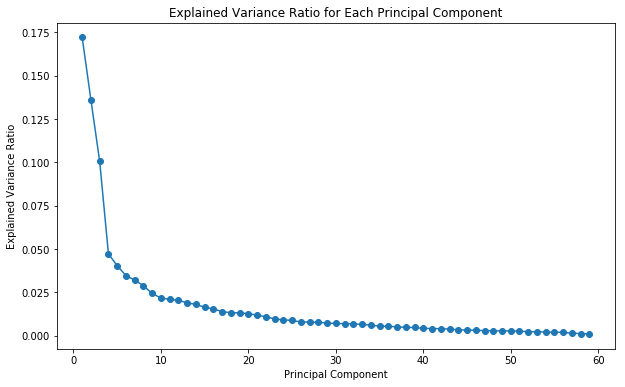

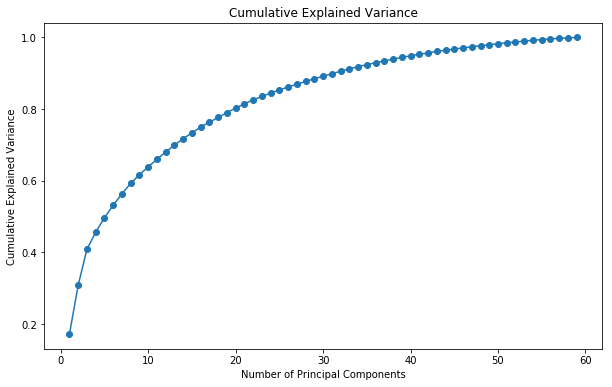

In [47]:
# Plot the explained variance ratio for each component
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title('Explained Variance Ratio for Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()







### Discussion 2.2: Perform Dimensionality Reduction

I will be retaining 59 transforms features and PCA components. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [48]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def weight_map(pca, i):
    data = pd.DataFrame(pca.components_, columns = column_names)
    return data.iloc[i].sort_values(ascending = False)
    

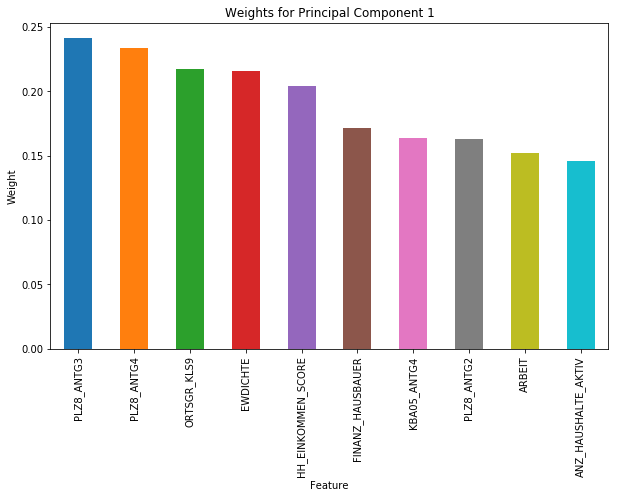

PLZ8_ANTG3             0.241046
PLZ8_ANTG4             0.233398
ORTSGR_KLS9            0.217279
EWDICHTE               0.215473
HH_EINKOMMEN_SCORE     0.204284
FINANZ_HAUSBAUER       0.171539
KBA05_ANTG4            0.163475
PLZ8_ANTG2             0.163109
ARBEIT                 0.152344
ANZ_HAUSHALTE_AKTIV    0.145661
Name: 0, dtype: float64


In [49]:
weight_map(pca , 0)

weights = weight_map(pca, 0)
top_10_weights = weights[:10]
# Create a bar plot
plt.figure(figsize=(10, 6))
top_10_weights.plot(kind='bar')
plt.title('Weights for Principal Component 1')
plt.xlabel('Feature')
plt.ylabel('Weight')
plt.show()

print(top_10_weights)

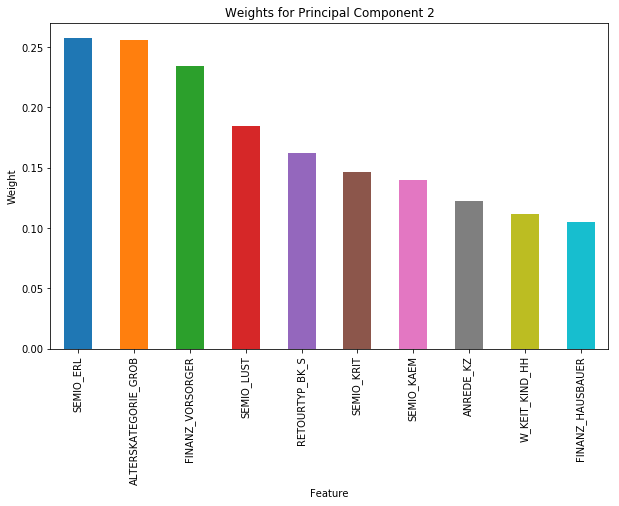

SEMIO_ERL               0.257457
ALTERSKATEGORIE_GROB    0.255934
FINANZ_VORSORGER        0.234569
SEMIO_LUST              0.184417
RETOURTYP_BK_S          0.161844
SEMIO_KRIT              0.146337
SEMIO_KAEM              0.140191
ANREDE_KZ               0.122191
W_KEIT_KIND_HH          0.111404
FINANZ_HAUSBAUER        0.105059
Name: 1, dtype: float64


In [50]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weight_map(pca , 0)

weights = weight_map(pca,1)
top_10_weights = weights[:10]
# Create a bar plot
plt.figure(figsize=(10, 6))
top_10_weights.plot(kind='bar')
plt.title('Weights for Principal Component 2')
plt.xlabel('Feature')
plt.ylabel('Weight')
plt.show()

print(top_10_weights)

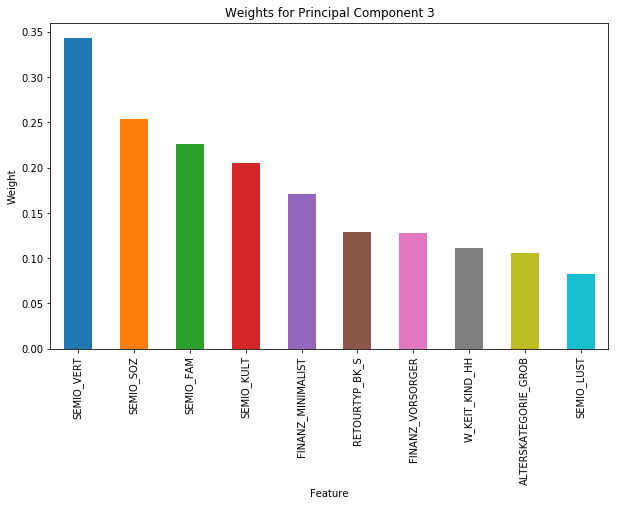

SEMIO_VERT              0.342966
SEMIO_SOZ               0.253986
SEMIO_FAM               0.226258
SEMIO_KULT              0.204805
FINANZ_MINIMALIST       0.170661
RETOURTYP_BK_S          0.129219
FINANZ_VORSORGER        0.127435
W_KEIT_KIND_HH          0.110989
ALTERSKATEGORIE_GROB    0.105601
SEMIO_LUST              0.082334
Name: 2, dtype: float64


In [51]:
weight_map(pca , 0)

weights = weight_map(pca, 2)
top_10_weights = weights[:10]
# Create a bar plot
plt.figure(figsize=(10, 6))
top_10_weights.plot(kind='bar')
plt.title('Weights for Principal Component 3')
plt.xlabel('Feature')
plt.ylabel('Weight')
plt.show()

print(top_10_weights)

### Discussion 2.3: Interpret Principal Components

**Principal Component 1:**

- Features with high positive weights: PLZ8_ANTG3, PLZ8_ANTG4, ORTSGR_KLS9, EWDICHTE, HH_EINKOMMEN_SCORE, etc.
- Features with high negative weights: PLZ8_ANTG1, KBA05_ANTG1, MOBI_REGIO, FINANZ_MINIMALIST, etc.
- This component seems to capture information related to the size and affluence of residential areas.

**Principal Component 2:**

- Features with high positive weights: ALTERSKATEGORIE_GROB, SEMIO_ERL, FINANZ_VORSORGER, SEMIO_LUST, etc.
- Features with high negative weights: DECADE, SEMIO_DOM, SEMIO_KAEM, ANREDE_KZ, etc.
- This component seems to capture information related to the age and personality characteristics of individuals.

**Principal Component 3:**

- Features with high positive weights: SEMIO_VERT, SEMIO_SOZ, SEMIO_FAM, SEMIO_KULT, etc.
- Features with high negative weights: FINANZ_MINIMALIST, RETOURTYP_BK_S, FINANZ_VORSORGER, W_KEIT_KIND_HH, etc.
- This component seems to capture information related to personality traits and financial behavior.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [52]:
from sklearn.cluster import MiniBatchKMeans

# Over a number of different cluster counts...
     
# Initialize a list to store the average distances
avg_distances = []

# Define the range of clusters we want to test
cluster_range = range(10, 31)

# run k-means clustering on the data and...

for num_clusters in cluster_range:
    # Create a KMeans instance with num_clusters clusters
    kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=0)
    
    # Fit the KMeans model to the data
    k_means_gen_model = kmeans.fit(pca_features)
    
    # compute the average within-cluster distances.
    avg_distance = -kmeans.score(pca_features) / pca_features.shape[0]
    avg_distances.append(avg_distance)
    

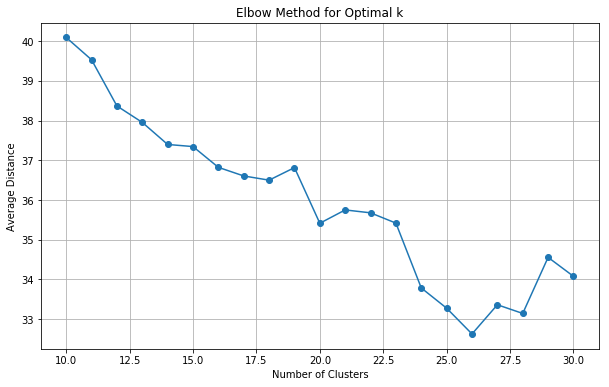

In [53]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, avg_distances, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Distance')
plt.grid(True)
plt.show()

In [54]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
optimal_k = 24
# Create an instance of KMeans with the selected number of clusters
kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=0)

# Fit the k-means model on the PCA-transformed data
kmeans.fit(pca_features)

# Obtain cluster assignments for the general demographics data
general_population_clusters = kmeans.predict(pca_features)


### Discussion 3.1: Apply Clustering to General Population

To determine the optimal number of clusters, I performed k-means clustering on the PCA-transformed data for a range of cluster counts, from 10 to 31. I then calculated the average within-cluster distances for each number of clusters.

I visualized this relationship using a plot, commonly referred to as an "Elbow plot." This plot displayed a decreasing trend in within-cluster distance as the number of clusters increased, but the rate of decrease slowed down after a certain point, creating an "elbow" shape. This point is typically considered the optimal number of clusters.

After careful analysis, it was observed that the rate of decrease in within-cluster distance became less pronounced after approximately 24 clusters. Therefore, I decided to segment the population into 24 clusters.

This decision strikes a balance between capturing meaningful distinctions within the data while avoiding an unnecessarily fine-grained segmentation that might be harder to interpret and utilize in downstream analyses.



### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [55]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')


In [56]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
threshold = 30
customers_clean = clean_data(customers, feat_info, threshold)

['KK_KUNDENTYP']
Before dropping rows missing many values (191652, 84)
After dropping rows missing many values (150592, 84)
Before Dropping Columns (150592, 66)
After Dropping Columns (150592, 59)


In [57]:
print(customers_clean.shape, azdias_cleaned.shape)

(150592, 59) (697859, 59)


In [58]:
#Step 1
customers_clean = customers_clean.dropna()
customer_columns = customers_clean.columns
customers_imputed = imputer.fit_transform(customers_clean)

In [59]:
customers_std = scaler.transform(customers_imputed)

In [60]:
# Apply PCA to the data
customers_pca = pca.transform(customers_std)

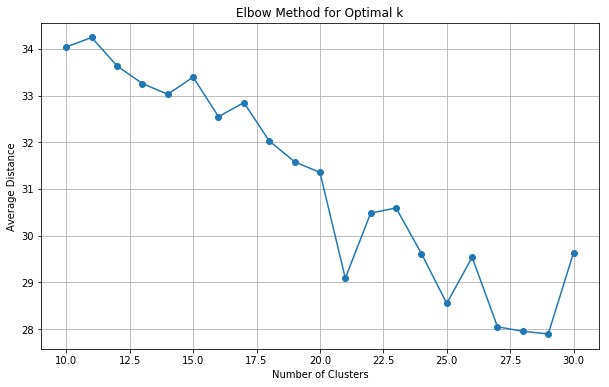

In [61]:
## Step 3: Clustering
# Cluster predictions for the general population demographics data.
from sklearn.cluster import MiniBatchKMeans

# Over a number of different cluster counts...
     
# Initialize a list to store the average distances
avg_distances_cus = []

# Define the range of clusters we want to test
cluster_range_cus = range(10, 31)

# run k-means clustering on the data and...

for num_clusters in cluster_range_cus:
    # Create a KMeans instance with num_clusters clusters
    kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=0)
    
    # Fit the KMeans model to the data
    kmeans.fit(customers_pca)
    
    # compute the average within-cluster distances.
    avg_distancecus = -kmeans.score(customers_pca) / customers_pca.shape[0]
    avg_distances_cus.append(avg_distancecus)
    
    
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, avg_distances_cus, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Distance')
plt.grid(True)
plt.show()

In [62]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
optimal_k_cus = 21
# Create an instance of KMeans with the selected number of clusters
kmeans_cus = MiniBatchKMeans(n_clusters=optimal_k_cus, random_state=0)

# Fit the k-means model on the PCA-transformed data
k_means_cus_model = kmeans_cus.fit(customers_pca)

# Obtain cluster assignments for the customer data
customer_population_clusters = kmeans_cus.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [63]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Compute cluster counts
customer_clusters_series = pd.Series(customer_population_clusters)
customer_cluster_counts = customer_clusters_series.value_counts().sort_index()


In [64]:
# Compute cluster counts
general_clusters_series = pd.Series(general_population_clusters)
general_cluster_counts = general_clusters_series.value_counts().sort_index()

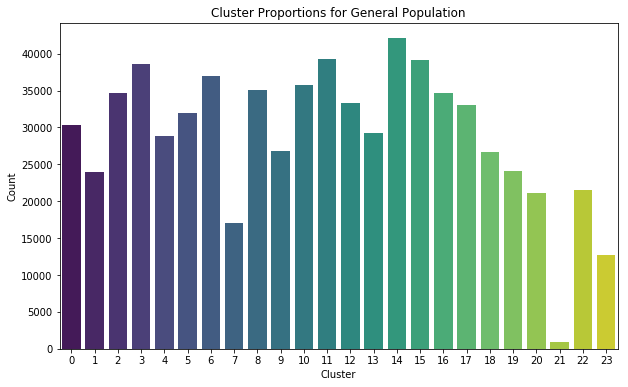

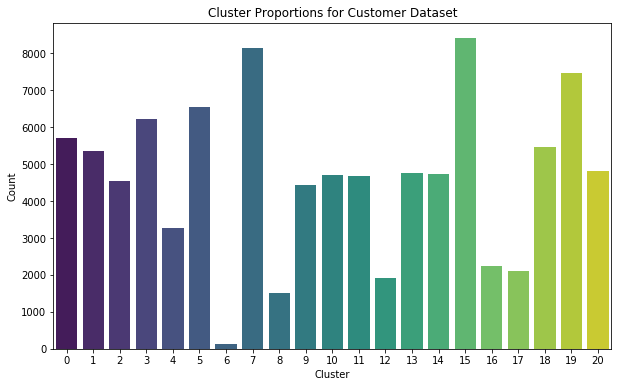

In [65]:
# Visualize the proportions
import seaborn as sns
import matplotlib.pyplot as plt

# Plot for general population
plt.figure(figsize=(10, 6))
sns.countplot(x=general_population_clusters, palette='viridis')
plt.title("Cluster Proportions for General Population")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

# Plot for customer dataset
plt.figure(figsize=(10, 6))
sns.countplot(x=customer_population_clusters,palette='viridis')
plt.title("Cluster Proportions for Customer Dataset")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()


In [66]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

cluster_20 = k_means_gen_model.cluster_centers_[20]
pca_20 = pca.inverse_transform(cluster_20)
overrepresented = scaler.inverse_transform(pca_20)

overrepresented = pd.Series(data = overrepresented, index = customer_columns)
display(overrepresented.head(10).sort_values())

GREEN_AVANTGARDE           0.181818
FINANZ_UNAUFFAELLIGER      2.000000
ANREDE_KZ                  2.000000
FINANZ_MINIMALIST          2.121212
FINANZ_SPARER              2.363636
FINANZ_ANLEGER             2.545455
ALTERSKATEGORIE_GROB       3.121212
FINANZ_VORSORGER           3.757576
FINANZ_HAUSBAUER           3.909091
GEBURTSJAHR              775.030303
dtype: float64

In [67]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cluster_16 = k_means_gen_model.cluster_centers_[16]
pca_16 = pca.inverse_transform(cluster_16)

underrepresented = scaler.inverse_transform(pca_16)
underrepresented_series = pd.Series(data=underrepresented, index=column_names)

display(underrepresented_series.head(10).sort_values())


GREEN_AVANTGARDE            0.344828
ANREDE_KZ                   1.017241
ALTERSKATEGORIE_GROB        1.982759
FINANZ_VORSORGER            2.137931
FINANZ_MINIMALIST           2.413793
FINANZ_ANLEGER              2.862069
FINANZ_HAUSBAUER            3.051724
FINANZ_UNAUFFAELLIGER       3.586207
FINANZ_SPARER               4.017241
GEBURTSJAHR              1399.500000
dtype: float64

### Discussion 3.3: Compare Customer Data to Demographics Data

Based on the clustering analysis, we can describe segments of the population that are relatively popular or unpopular with the mail-order company.

Segments Popular with the Mail-Order Company:
1. **Cluster 20 (Overrepresented)**: This segment is relatively more popular with the mail-order company. People in this cluster tend to exhibit characteristics like being part of the "GREEN_AVANTGARDE", being male (ANREDE_KZ), and having certain financial behaviors like being financially inconspicuous (FINANZ_UNAUFFAELLIGER) or being an investor (FINANZ_ANLEGER). They are also more likely to be older (ALTERSKATEGORIE_GROB) and have higher financial affluence.

2. **Cluster 16 (Underrepresented)**: This segment is relatively less popular with the mail-order company. People in this cluster are less likely to be customers. They tend to exhibit characteristics like not being part of the "GREEN_AVANTGARDE", being female (ANREDE_KZ), and having financial behaviors like being a minimalistic spender (FINANZ_MINIMALIST) or being financially inconspicuous (FINANZ_UNAUFFAELLIGER). They are also more likely to be younger (ALTERSKATEGORIE_GROB) and have lower financial affluence.

In summary, the mail-order company seems to attract and cater more to segments of the population that are older, more financially affluent, and exhibit specific financial behaviors.

Segments Unpopular with the Mail-Order Company:
1. **Cluster 16 (Underrepresented)**: This segment is relatively less popular with the mail-order company. People in this cluster tend to be younger, less financially affluent, and exhibit different financial behaviors compared to the segments that are more popular with the company.

2. **Cluster 20 (Overrepresented)**: This segment is relatively more popular with the mail-order company. People in this cluster tend to be older, more financially affluent, and exhibit specific financial behaviors that align with the company's target demographic.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.